In [1]:
from moist_konrad import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%%time
#### PRECIPITATION TEST
heat_sink = 0.
E_imbalance = 0.
opacity = 66.
albedo = 0.2

plev, phlev = konrad.utils.get_pressure_grids(1000e2, 100, 128)
atmosphere = konrad.atmosphere.Atmosphere(phlev)
clearsky = konrad.cloud.ClearSky.from_atmosphere(atmosphere)
surface = konrad.surface.SlabOcean(
    temperature=288,
    heat_sink=0,
    depth = 50,
    albedo = 0.5)

print(surface.albedo)
surface.albedo = albedo
print(surface.albedo)

radiation = konrad.radiation.RRTMG(solar_constant=551.58-opacity)

conv_top = coldpoint(atmosphere['T'][0])

humidity = konrad.humidity.FixedRH(
    rh_func=konrad.humidity.Manabe67(rh_surface=0.77),
)

RH = manabe_rh(0.77,atmosphere['plev'])
atmosphere['H2O'][0] = rh_to_vmr(RH,atmosphere['T'][0],atmosphere['plev'],conv_top)
T_atm_low = surface['temperature'].copy()

ndays = 15000
timestep = 0.5 #days
nsteps = int(ndays/timestep)

printcounter = 0
status = 0

tol = 1e-5

dE_1 = [1e8]
OLR_1 = [1e8]
NSW_1 = [1e8]
T_sfc_1 = [1e8]
toa_1 = [1e8]
T_low_1 = [1e8]

#### RCE FOR PRESENT-DAY CO2
atmosphere['CO2'][0] = 348/1e6
for i in range(nsteps):
    
    #surface fluxes
    z = height(atmosphere['plev'],atmosphere['T'][0].copy(),
               atmosphere['phlev'][0],surface['temperature'].copy())
    zini = 10
    
    T_ini,vmr_ini = T_vmr_z(T_atm_low,atmosphere['T'][0][0].copy(),
                            atmosphere['H2O'][0,0].copy(),atmosphere['H2O'][0,1].copy(),
                            z,zini)
    
    LH = latent_heat(vmr_ini, T_ini,atmosphere['phlev'][0])
    SH = sensible_heat(T_ini,surface['temperature'].copy(),atmosphere['phlev'][0]) + E_imbalance
    
    #convective adjustment of the armosphere
    atmosphere,surface,radiation,net_rad_surface,atm_rad,\
    T_atm_low,E_imbalance,prec_mass,RH,cold_point,conv_top = RCPE_step(timestep,
                                                                          atmosphere,surface,radiation,clearsky,
                                                                          SH,LH,albedo,
                                                                          conv_top,
                                                                       strong_coupling = True)
    
        
    
    #update surface temperature with energetic fluxes (latent and radiative)
    surface['temperature'] += ((net_rad_surface - SH - LH)
                               * seconds_day * timestep / surface.heat_capacity)
    
    
    
    status += 1
    if printcounter == 200:
        print(status/2)
        printcounter = 0
        print(surface['temperature'],SH,LH,prec_mass*Lv/seconds_day/timestep,
              E_imbalance,np.maximum(0.,np.minimum(1.,LH/(LH+SH))))
        print(RH[0])
        print(T_atm_low)
    printcounter += 1

    
    dE_1.append(E_imbalance.copy())
    OLR_1.append(radiation['lw_flxu'][0,-1].copy() - radiation['lw_flxd'][0,-1].copy())
    NSW_1.append(radiation['sw_flxd'][0,-1].copy() - radiation['sw_flxu'][0,-1].copy())
    T_sfc_1.append(surface['temperature'].copy())
    toa_1.append(radiation['toa'].copy())
    T_low_1.append(T_ini.copy())
    
    if abs(T_sfc_1[i]-T_sfc_1[i-1])<tol and abs(toa_1[i]-toa_1[i-1])<tol:
        print(i)
        break
    
    
### Record RCE 1xCO2
RH_1 = RH.copy()
Mw_1 = column_water_mass(atmosphere['H2O'][0],atmosphere['phlev']).copy()
vmr_1 = atmosphere['H2O'][0].copy()
T_atm_1 = atmosphere['T'][0].copy()
SH_1 = SH.copy()
LH_1 = LH.copy()
Prec_1 = prec_mass.copy()/timestep
atm_rad_1 = atm_rad.copy()
sfc_rad_1 = net_rad_surface.copy()

0.5
0.2
100.5
[288.97308865] [21.51430234] [94.90328459] [94.49924876] [-1.10673528] [0.81519715]
0.708787079413596
[288.97308865]
200.5
[289.72862119] [20.89924965] [98.48743901] [98.08114138] [-1.27314996] [0.82494489]
0.7111454735143409
[289.72862119]
300.5
[290.41441558] [20.35094084] [101.54874586] [101.14877237] [-1.42730966] [0.83305174]
0.7140291600919544
[290.41441558]
400.5
[291.04116648] [19.85685092] [104.41106876] [104.03037056] [-1.56812683] [0.84020936]
0.7166256454516621
[291.04116648]
500.5
[291.61453421] [19.424825] [107.07240418] [106.71048597] [-1.68301973] [0.84644071]
0.719005577939128
[291.61453421]
600.5
[292.1389989] [19.02140524] [109.59206541] [109.23880557] [-1.80093297] [0.8521041]
0.7210696666857794
[292.1389989]
700.5
[292.61859411] [18.65929673] [111.93381098] [111.60211712] [-1.90741778] [0.85711882]
0.7229410036123373
[292.61859411]
800.5
[293.05734588] [18.34126257] [114.11522756] [113.80128576] [-1.99448963] [0.86152991]
0.7246289408003544
[293.05734

6700.5
[297.7088473] [15.19918185] [139.14084494] [139.13877154] [-2.89744315] [0.90152145]
0.7420836108230898
[297.7088473]
13599
CPU times: user 7min 13s, sys: 422 ms, total: 7min 14s
Wall time: 7min 14s


In [3]:
print(Prec_1)
print(LH_1)
print(SH_1)
print(sfc_rad_1)
print(sfc_rad_1-SH_1-LH_1)
print(sfc_rad_1+atm_rad_1)
print(toa_1[-1])
print(dE_1[-1])
print(LH_1/Lv * seconds_day)
print(RH_1[0])
print(T_sfc_1[-1])
print(Mw_1)

[4.80713102]
[139.15309779]
[15.19728029]
154.3983387350986
[0.04796066]
0.050746723331656085
[0.05074672]
[-2.89848512]
[4.80720818]
0.7420901949984745
[297.7108785]
43.5361943997232


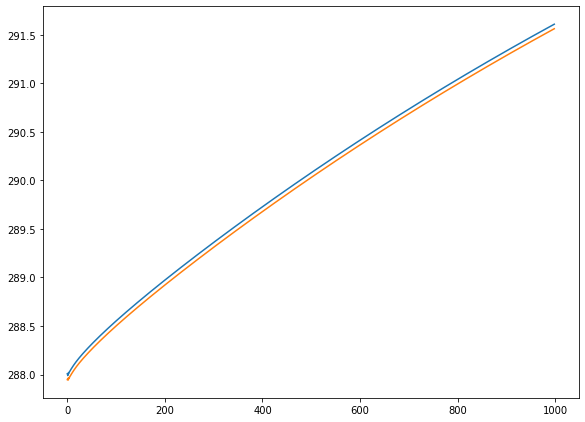

In [7]:
fig, ax = plt.subplots(figsize=(1.5*6.4, 1.5*4.8))
T_sfc_rec = np.array(T_sfc_1[1:1000])
T_low_rec = np.array(T_low_1[1:1000])
plt.plot(T_sfc_rec)
plt.plot(T_low_rec)
plt.show()

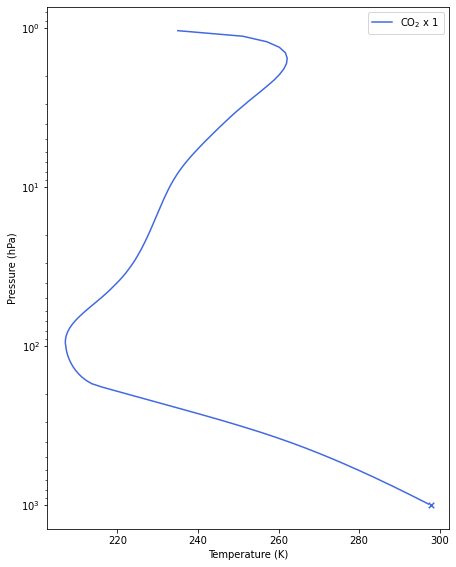

In [5]:
fig, ax = plt.subplots(figsize=(1.5*4.8, 1.5*6.4))


ax.plot(T_atm_1, atmosphere['plev']/100,
               alpha = 1, color = 'royalblue', lw = 1.5, label = 'CO$_2$ x 1')
ax.scatter(T_sfc_1[-1], atmosphere['phlev'][0]/100,
               alpha = 1, color = 'royalblue', s = 30, marker ='x')

ax.set_yscale('log')
ax.yaxis.set_inverted(True)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pressure (hPa)')

plt.legend()
plt.show()

In [6]:
print(10/seconds_day/timestep)

0.0002314814814814815
